<a href="https://colab.research.google.com/github/Tswy22/COVID19_ETL_Pipeline/blob/main/COVID19_ETL_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [1]:
!pip install pandas requests sqlalchemy psycopg2-binary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.0 MB/s eta 0:00:00


In [20]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.9 MB/s eta 0:00:00


In [22]:
!pip install streamlit pyngrok

In [8]:
import requests
import pandas as pd

url = 'https://covid19.ddc.moph.go.th/api/Cases/timeline-cases-all'
response = requests.get(url)
data = response.json()

In [9]:
print(type(data))
print(data[:1])

<class 'list'>
[{'year': 2021, 'weeknum': 52, 'new_case': 3011, 'total_case': 2226446, 'new_case_excludeabroad': 2869, 'total_case_excludeabroad': 2218200, 'new_recovered': 3315, 'total_recovered': 2171809, 'new_death': 10, 'total_death': 21708, 'case_foreign': 142, 'case_prison': 57, 'case_walkin': 2716, 'case_new_prev': 3111, 'case_new_diff': -100, 'death_new_prev': 26, 'death_new_diff': -16, 'update_date': '2024-12-23 12:16:13'}]


In [10]:
df = pd.DataFrame(data)

In [11]:
df_clean = df[[
    'year',
    'weeknum',
    'new_case',
    'total_case',
    'new_recovered',
    'total_recovered',
    'new_death',
    'total_death',
    'update_date'
]].copy()


In [12]:
df_clean['update_date'] = pd.to_datetime(df_clean['update_date'])

In [13]:
df_clean['date'] = pd.to_datetime(
    df_clean['year'].astype(str) + df_clean['weeknum'].astype(str) + '1',
    format='%G%V%u'
)

In [14]:
df_clean.head()

,year,weeknum,new_case,total_case,new_recovered,total_recovered,new_death,total_death,update_date,date
0,2021,52,3011,2226446,3315,2171809,10,21708,2024-12-23 12:16:13,2021-12-27
1,2022,1,34593,2261039,19453,2191262,105,21813,2024-12-23 12:16:13,2022-01-03
2,2022,2,55369,2316408,25862,2217124,103,21916,2024-12-23 12:16:13,2022-01-10
3,2022,3,53406,2369814,47440,2264564,103,22019,2024-12-23 12:16:13,2022-01-17
4,2022,4,54276,2424090,53442,2318006,126,22145,2024-12-23 12:16:13,2022-01-24


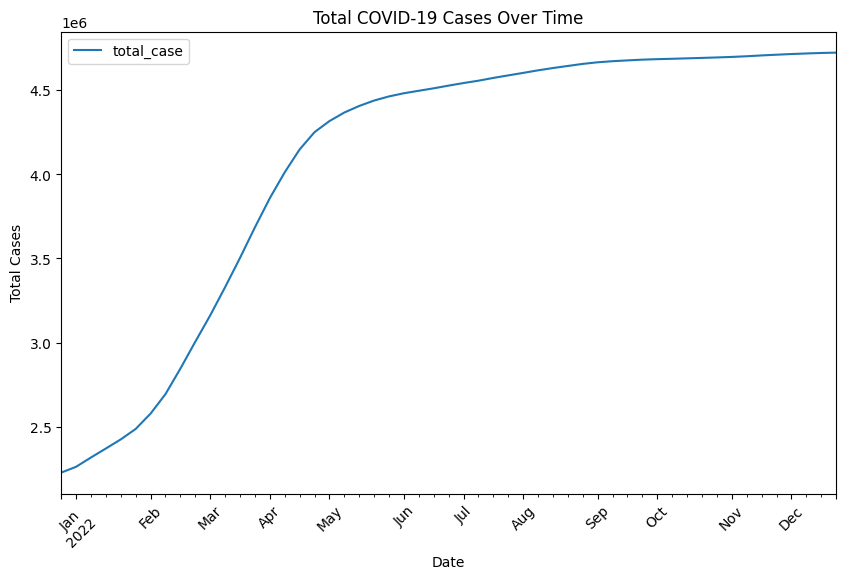

In [15]:
# ดูกราฟยอดติดเชื้อสะสม
import matplotlib.pyplot as plt

df_clean.plot(x='date', y='total_case', title='Total COVID-19 Cases Over Time', kind='line', figsize=(10, 6))
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.show()

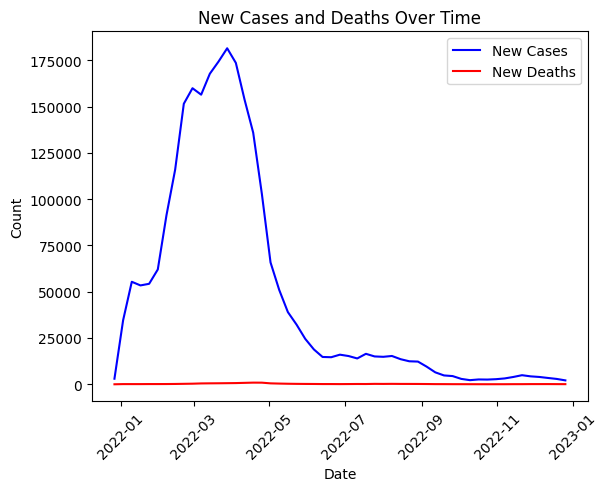

In [16]:
import seaborn as sns

# กราฟการเปลี่ยนแปลงของผู้ติดเชื้อใหม่
sns.lineplot(data=df_clean, x='date', y='new_case', label='New Cases', color='blue')
sns.lineplot(data=df_clean, x='date', y='new_death', label='New Deaths', color='red')
plt.title("New Cases and Deaths Over Time")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.show()

In [17]:
df_clean.to_csv('covid_weekly_analysis.csv', index=False)

In [18]:
import sqlite3

# เชื่อมต่อกับฐานข้อมูล SQLite
conn = sqlite3.connect('covid_data.db')
df_clean.to_sql('covid_cases', conn, if_exists='replace', index=False)
conn.close()

In [41]:
# สร้างไฟล์ app.py

app_code = """
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# อ่านข้อมูลจากไฟล์ CSV
df = pd.read_csv('/content/covid_weekly_analysis.csv')

# Clean ข้อมูล โดยการลบค่า NaN (กรณีที่ยังไม่ได้ clean ข้อมูล)
df_clean = df.dropna()

# เริ่มต้นหน้าเว็บ
st.title("COVID-19 Weekly Data Dashboard")

# แสดง DataFrame
st.subheader("ข้อมูลดิบ")
st.write(df_clean.head())

# ตัวกรองปี
selected_year = st.selectbox("เลือกปี", df_clean['year'].unique())

# กรองข้อมูลตามปีที่เลือก
filtered_data = df_clean[df_clean['year'] == selected_year]

# แสดงกราฟเส้น: ยอดผู้ติดเชื้อรายสัปดาห์
st.subheader(f"ยอดผู้ติดเชื้อรายสัปดาห์ ปี {selected_year}")
plt.figure(figsize=(10, 5))
plt.plot(filtered_data['weeknum'], filtered_data['new_case'], marker='o')
plt.xlabel('Week Number')
plt.ylabel('Number of New Infections')
plt.title(f'Number of New Infections Per Week in {selected_year}')
st.pyplot(plt)
"""

# บันทึกเป็นไฟล์ app.py
with open("app.py", "w") as file:
    file.write(app_code)

print("ไฟล์ app.py ถูกสร้างแล้ว!")

ไฟล์ app.py ถูกสร้างแล้ว!


In [42]:
# เพิ่ม authtoken
!ngrok config add-authtoken 2ukgmGwF9B3tGIfylpnCD1NcyX9_6jnteeQUzmR3GjPJVNmUA

import streamlit as st
from pyngrok import ngrok

# สร้าง tunnel
public_url = ngrok.connect(8501)
print('Streamlit app is live at:', public_url)

# รัน streamlit app
!streamlit run app.py &

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Streamlit app is live at: NgrokTunnel: "https://26d0-35-231-174-42.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.231.174.42:8501



  Stopping...
